In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

C:\Users\hp\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


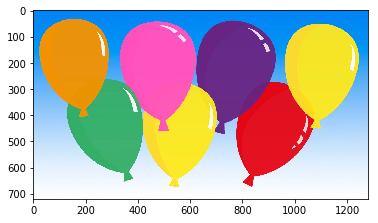

In [3]:
IMAGE_PATH = os.path.join(ROOT_DIR, "try1.jpg")
image=plt.imread(IMAGE_PATH)
plt.imshow(image)

In [4]:
############################################################
#  Configurations
############################################################


class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [5]:
def detect_area(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    gray = np.zeros_like(gray) 
    no_instance=mask.shape[2]
    mask_all = (np.sum(mask, -1, keepdims=True) >= 1)
    splash = np.where(mask_all, image, gray).astype(np.uint8)
    instances={}
    instances[0]=splash
    for i in range(no_instance):
        in_mask=mask[:,:,i]
        in_mask=np.reshape(in_mask,(mask.shape[0],mask.shape[1],1))
        # Copy color pixels from the original color image where mask is set
        instance = np.where(in_mask, image, gray).astype(np.uint8)
        instances[i+1]=instance
        #save file
        file_name = str(i)+"splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, instance)
    else:
        splash = gray.astype(np.uint8)
    return instances

In [6]:
def detect_and_extract(model, image_path=None):
    # Run model detection and generate the color splash effect
    #print("Running on {}".format(args.image))
    # Read image
    image = skimage.io.imread(image_path)
    # Detect objects
    r = model.detect([image], verbose=1)[0]
    # Color splash
    instances=detect_area(image, r['masks'])
        
    return instances

In [7]:
#for inference
class InferenceConfig(BalloonConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [8]:
model = modellib.MaskRCNN(mode="inference", config=config,model_dir="logs/")
weights_path = COCO_WEIGHTS_PATH
print("Loading weights ", weights_path)

Loading weights  C:\Users\hp\Documents\Mask_RCNN-master\Mask_RCNN-master\mask_rcnn_balloon.h5


In [9]:
from mrcnn import model as modellib, utils
model.load_weights(weights_path, by_name=True)

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


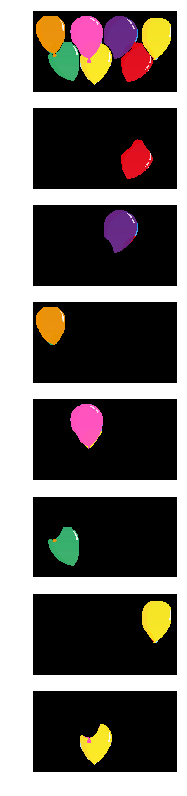

In [10]:
#for inference
instances=detect_and_extract(model, image_path=IMAGE_PATH)
fig, axs = plt.subplots(ncols=1, nrows=len(instances), figsize=(12, 14))
axs = axs.ravel()
for index in range(len(instances)):
    axs[index].imshow(instances[index])
    axs[index].set_axis_off()

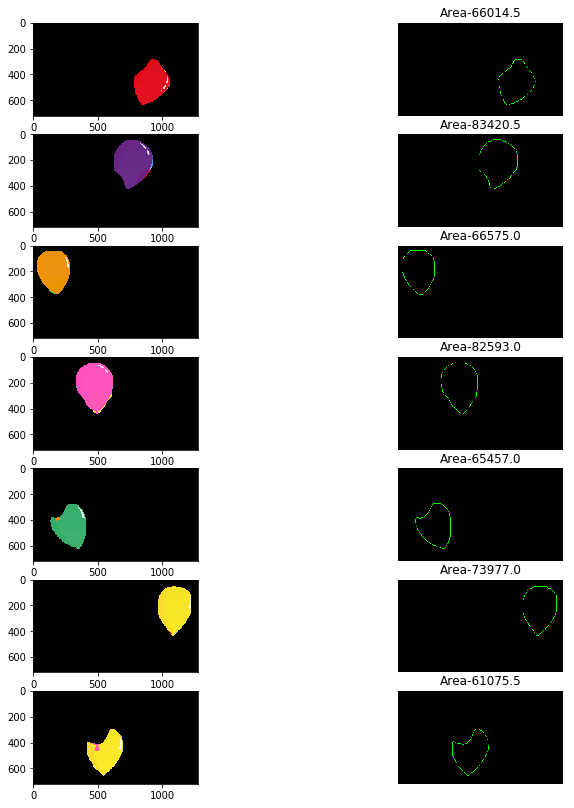

In [38]:
contours_image={}
areas={}
areas[0]=0.0
final = np.zeros_like(instances[0])
for index in range(1,len(instances)):
    blank = np.zeros_like(instances[0])
    gray = cv2.cvtColor(instances[index], cv2.COLOR_RGB2GRAY)
    ret,thresh = cv2.threshold(gray,0,500,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(blank, contours, 0, (0,255,0), 3)
    cv2.drawContours(final, contours, 0, (0,255,0), 3)
    area = 0
    for i in contours:
        cont=i
        area += cv2.contourArea(cont)
    areas[index]=area
    contours_image[index]=blank
contours_image[0]=final
fig, axs = plt.subplots(ncols=1, nrows=len(instances), figsize=(12, 14))
index=1
i=1
num=len(contours_image)
while(i<num):
    plt.subplot(num-1, 2, index)
    plt.imshow(instances[i])
    plt.subplot(num-1, 2, index+1)
    plt.axis("off")
    plt.title("Area-"+str(areas[i]))
    plt.imshow(contours_image[i])
    index=index+2
    i=i+1 


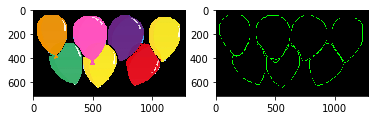

In [36]:
plt.subplot(1, 2,1)
plt.imshow(instances[0])
plt.subplot(1, 2,2)
plt.imshow(contours_image[0])